In [174]:
import os
import numpy as np
import matplotlib
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.manifold import TSNE
import phate
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt


In [11]:
os.chdir('..')
import data_loader

In [3]:
PROJECT_PATH = '/home/mila/s/shuang.ni/phate_genetics/shuang/'
SCRATCH_PATH = '/home/mila/s/shuang.ni/scratch/phate_genetics/'
DATA_PATH = SCRATCH_PATH + '1KGP/'
SAVE_PATH = SCRATCH_PATH + 'results/'
Figure_PATH = PROJECT_PATH + 'figures/'

In [4]:
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed_V1.hdf5'

In [5]:
inputs, class_labels, samples, snp_names, class_label_names = data_loader.load_data_1000G(os.path.join(DATA_PATH, fname))
label_with_names, label_with_superpop_names = data_loader.preprocess_labels_1000G(class_labels, class_label_names)

In [6]:
pca_obj = sklearn.decomposition.PCA(n_components=100, random_state=42)
pca_input = pca_obj.fit_transform(inputs)

# PHATE

In [175]:
# initial phate embedding
phate_operator_10d = phate.PHATE(random_state=42, 
                                n_components=3, 
                                knn=5, 
                                decay=60,
                                n_pca=None)
phate_operator_10d.fit(pca_input)
phate_emb_10d = phate_operator_10d.transform()

Running PHATE on 2322 observations and 100 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.31 seconds.
  Calculating affinities...
  Calculated affinities in 0.01 seconds.
Calculated graph and diffusion operator in 0.33 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.09 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.39 seconds.
Calculated landmark operator in 1.89 seconds.
Calculating optimal t...
  Automatically selected t = 25
Calculated optimal t in 0.64 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.38 seconds.
Calculating metric MDS...
Calculated metric MDS in 10.34 seconds.


In [189]:
# hdbscan parameters
min_points = 20 # 25
eps = 0.0
min_samples = 1
metric = 'euclidean'

In [177]:
# use hdbscan package
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_points,min_samples=min_samples, 
                            cluster_selection_epsilon=eps, metric = metric)
clusterer.fit(phate_emb_10d)

HDBSCAN(min_cluster_size=15, min_samples=5)

In [190]:
# OR use sklearn
clusterer = sklearn.cluster.HDBSCAN(min_cluster_size=min_points, cluster_selection_epsilon=eps)
clusterer.fit(phate_emb_10d)

HDBSCAN(min_cluster_size=20)

In [191]:
print('Number of clusters:', str(max(clusterer.labels_)))
print('Number unassigned:', str(np.sum(clusterer.labels_ == -1)))

Number of clusters: 18
Number unassigned: 192


In [192]:
df = pd.DataFrame(columns=['HDBSCAN Cluster', 'Population'])
df['HDBSCAN Cluster'] = clusterer.labels_
df['Population'] = label_with_names

# Filter out the -1 cluster
df = df[df['HDBSCAN Cluster'] != -1]
# Create a cross-tabulation of clusters and populations
crosstab = pd.crosstab(df['HDBSCAN Cluster'], df['Population'])
# Convert counts to proportions
proportions = crosstab.div(crosstab.sum(axis=1), axis=0)

# Reorder the populations to match the clusters
ordered_populations = proportions.idxmax().sort_values().index
proportions = proportions[ordered_populations]

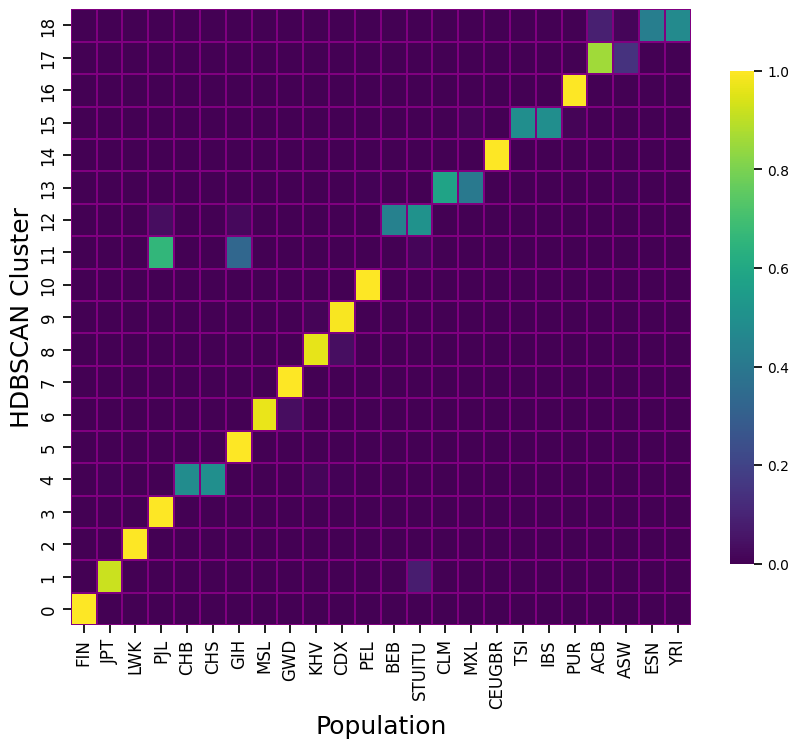

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(proportions, cmap='viridis', annot=False,linewidths=0.05, linecolor='purple', 
                      cbar_kws={'shrink': 0.8})
heatmap.invert_yaxis()
plt.xlabel('Population')
plt.ylabel('HDBSCAN Cluster')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)
# plt.title('Proportions of each 1KGP population contained within a given cluster')

# Adjust the color bar tick labels font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
plt.show()
# plt.savefig(Figure_PATH +'1000G_HDBSCAN_population.pdf', bbox_inches = 'tight')

# t-SNE

In [195]:
tsne_op = TSNE(n_components=10, perplexity=20, n_iter=1000, method='exact',random_state=42) # , method='exact'
tsne_embedding = tsne_op.fit_transform(pca_input)

/home/mila/s/shuang.ni/.conda/envs/genetics/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [127]:
# hdbscan parameters
min_points = 4 # 25
eps = 0.3
min_samples = None
metric = 'euclidean'
alpha = 1.0

In [128]:
# use hdbscan package
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_points,min_samples=min_samples, alpha = alpha,
                            cluster_selection_epsilon=eps, metric = metric)
clusterer.fit(tsne_embedding)
print('Number of clusters:', str(max(clusterer.labels_)))
print('Number unassigned:', str(np.sum(clusterer.labels_ == -1)))

Number of clusters: 17
Number unassigned: 79


In [129]:
df = pd.DataFrame(columns=['HDBSCAN Cluster', 'Population'])
df['HDBSCAN Cluster'] = clusterer.labels_
df['Population'] = label_with_names

# Filter out the -1 cluster
df = df[df['HDBSCAN Cluster'] != -1]
# Create a cross-tabulation of clusters and populations
crosstab = pd.crosstab(df['HDBSCAN Cluster'], df['Population'])
# Convert counts to proportions
proportions = crosstab.div(crosstab.sum(axis=1), axis=0)

# Reorder the populations to match the clusters
ordered_populations = proportions.idxmax().sort_values().index
proportions = proportions[ordered_populations]

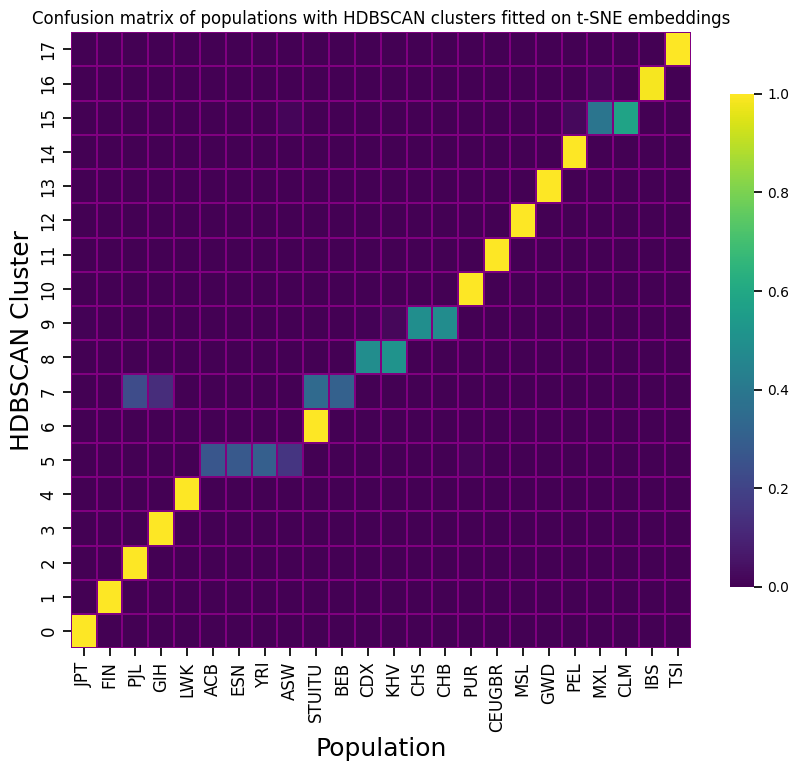

In [130]:

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(proportions, cmap='viridis', annot=False,linewidths=0.05, linecolor='purple', 
                      cbar_kws={'shrink': 0.8})
heatmap.invert_yaxis()
plt.xlabel('Population')
plt.ylabel('HDBSCAN Cluster')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)
plt.title('Confusion matrix of populations with HDBSCAN clusters fitted on t-SNE embeddings', fontsize=12)

# Adjust the color bar tick labels font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
plt.show()
# plt.savefig(Figure_PATH +'1000G_HDBSCAN_population.pdf', bbox_inches = 'tight')

# PCA

In [154]:
pca_obj = sklearn.decomposition.PCA(n_components=30, random_state=42)
pca_embedding = pca_obj.fit_transform(inputs)

In [170]:
# hdbscan parameters
min_points = 2 # 25
eps = 0.3
min_samples = None
metric = 'euclidean'
alpha = 1.8

In [171]:
# use hdbscan package
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_points,min_samples=min_samples, alpha = alpha,
                            cluster_selection_epsilon=eps, metric = metric)
clusterer.fit(pca_embedding)
print('Number of clusters:', str(max(clusterer.labels_)))
print('Number unassigned:', str(np.sum(clusterer.labels_ == -1)))

Number of clusters: 20
Number unassigned: 167


In [172]:
df = pd.DataFrame(columns=['HDBSCAN Cluster', 'Population'])
df['HDBSCAN Cluster'] = clusterer.labels_
df['Population'] = label_with_names

# Filter out the -1 cluster
df = df[df['HDBSCAN Cluster'] != -1]
# Create a cross-tabulation of clusters and populations
crosstab = pd.crosstab(df['HDBSCAN Cluster'], df['Population'])
# Convert counts to proportions
proportions = crosstab.div(crosstab.sum(axis=1), axis=0)

# Reorder the populations to match the clusters
ordered_populations = proportions.idxmax().sort_values().index
proportions = proportions[ordered_populations]

In [ ]:
# 3 PCs
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(proportions, cmap='viridis', annot=False,linewidths=0.05, linecolor='purple', 
                      cbar_kws={'shrink': 0.8})
heatmap.invert_yaxis()
plt.xlabel('Population')
plt.ylabel('HDBSCAN Cluster')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)
plt.title('Confusion matrix of populations with HDBSCAN clusters fitted on 3 PCs', fontsize=12)

# Adjust the color bar tick labels font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
plt.show()

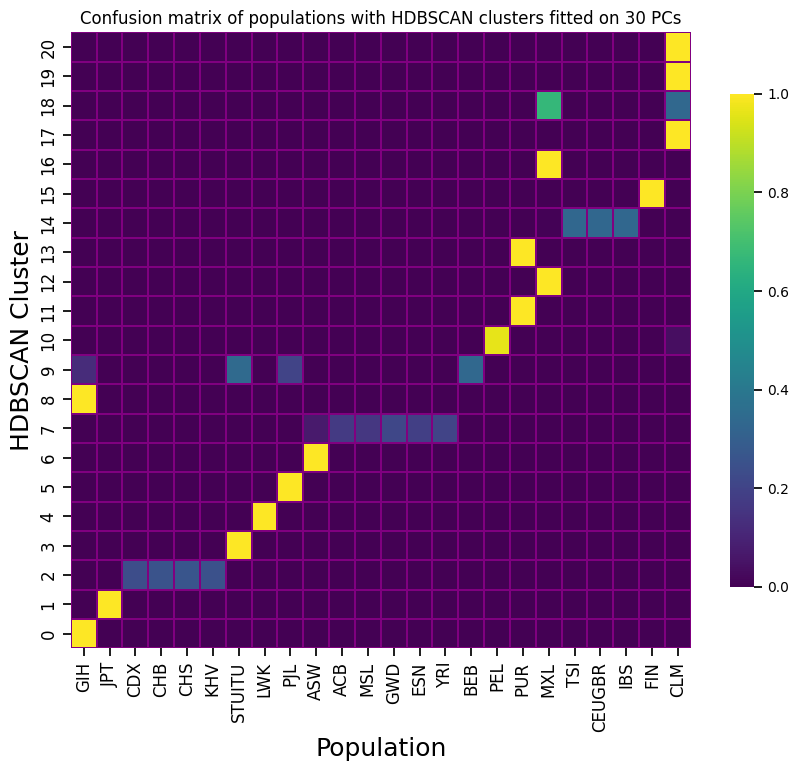

In [173]:
# 30 PCs
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(proportions, cmap='viridis', annot=False,linewidths=0.05, linecolor='purple', 
                      cbar_kws={'shrink': 0.8})
heatmap.invert_yaxis()
plt.xlabel('Population')
plt.ylabel('HDBSCAN Cluster')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12)
plt.title('Confusion matrix of populations with HDBSCAN clusters fitted on 30 PCs', fontsize=12)

# Adjust the color bar tick labels font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
plt.show()